In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import newaxis
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    LSTM,
    BatchNormalization,
    LayerNormalization,
    Activation,
    Dropout,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [1]:
WINDOW_SIZE = 500
EMG_CHANNELS = 2

VAL_RATE = 0.2
TEST_RATE = 0.2

L2_NORM = 0.01
DROPOUT_RATE = 0.5

LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999

TRUNCATION_UNIT = 64

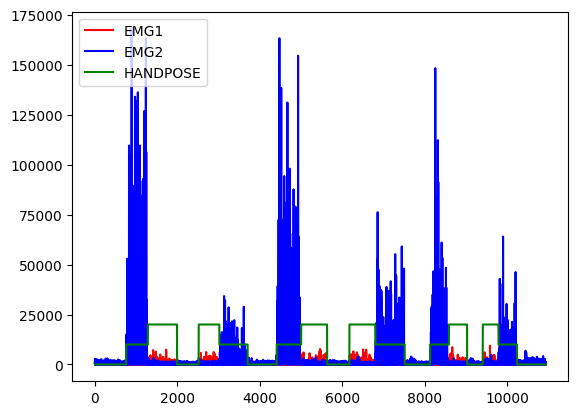

<class 'numpy.ndarray'> (10939, 3)


In [68]:
dataset = pd.read_csv(
    "/home/Hand-Gesture-Recognition-Using-ML-with-EMG-Sensors/2_EMG_Sensors_Discrete.csv"
)
plt.plot(dataset.iloc[:, 1], "r")
plt.plot(dataset.iloc[:, 0], "b")
dataset_y = list(i * 10000 for i in dataset.iloc[:, 2])
plt.plot(dataset_y, "g")
plt.legend(["EMG1", "EMG2", "HANDPOSE"], loc="upper left")
plt.show()

dataset = dataset.values.reshape(dataset.shape)
print(type(dataset), dataset.shape)

In [69]:
X, y = list(), list()
for i, _ in enumerate(dataset):
    if i + WINDOW_SIZE > len(dataset) - 1:
        break
    seq_X = dataset[i : i + WINDOW_SIZE, :-1]
    seq_y = dataset[i + WINDOW_SIZE, -1]
    # one-hot encoding
    if seq_y == 0:
        seq_y = (1, 0, 0)
    elif seq_y == 1:
        seq_y = (0, 1, 0)
    elif seq_y == 2:
        seq_y = (0, 0, 1)

    X.append(seq_X)
    y.append(seq_y)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(10439, 500, 2) (10439, 3)


In [70]:
dataset_size = len(X)
val_size = int(dataset_size * VAL_RATE)
test_size = int(dataset_size * TEST_RATE)
train_size = dataset_size - val_size - test_size

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=train_size, shuffle=True
)
# X_train, y_train = X[:train_size, :], y[:train_size, :]
# X_val, y_val = (
#     X[train_size : train_size + val_size, :],
#     y[train_size : train_size + val_size, :],
# )
# X_test, y_test = (
#     X[train_size + val_size :, :],
#     y[train_size + val_size :, :],
# )

print(
    X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
)

(6265, 500, 2) (6265, 3) (2087, 500, 2) (2087, 3) (2087, 500, 2) (2087, 3)


In [ ]:
model = Sequential()
# model.add(
#     Conv2D(
#         32,
#         kernel_size=(4, 2),
#         padding="same",
#         input_shape=(1000, 8, 1),
#         kernel_regularizer=regularizers.L2(l2=L2_NORM),
#     )
# )
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(rate=DROPOUT_RATE))
# model.add(MaxPooling2D(pool_size=(5, 2)))  # output_shape = (200, 4, 1)

model.add(
    LSTM(
        50,
        input_shape=(WINDOW_SIZE, EMG_CHANNELS),
        kernel_regularizer=regularizers.L1L2(0, L2_NORM),
    )
)
model.add(LayerNormalization())
model.add(Activation(activations.tanh))
model.add(Dropout(rate=DROPOUT_RATE))
model.add(Dense(3, activation="softmax"))

optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

In [ ]:
checkpoint_filepath = "/home/Hand-Gesture-Recognition-Using-ML-with-EMG-Sensors/checkpoints/{epoch:02d}-{val_accuracy:.3f}"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    save_weights_only=False,
    save_best_only=True,
    verbose=1,
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[model_checkpoint_callback],
)

final train loss, final val loss: 0.04293966293334961 0.03426007181406021


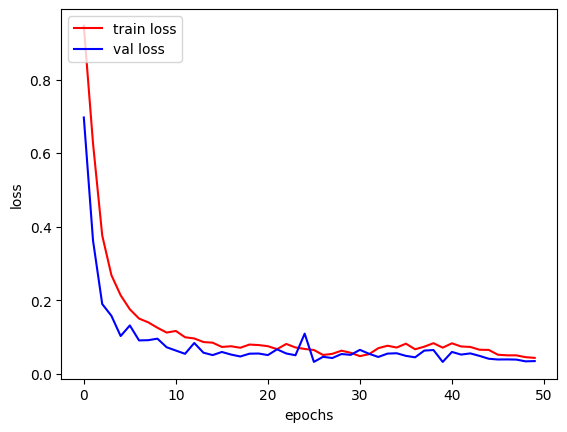

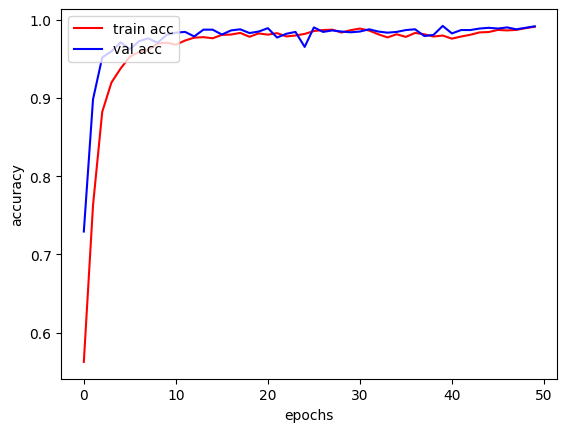

In [90]:
print(
    "final train loss, final val loss:",
    history.history["loss"][-1],
    history.history["val_loss"][-1],
)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(history.history["loss"], "r")
plt.plot(history.history["val_loss"], "b")
plt.legend(["train loss", "val loss"], loc="upper left")
plt.show()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history.history["accuracy"], "r")
plt.plot(history.history["val_accuracy"], "b")
plt.legend(["train acc", "val acc"], loc="upper left")

66/66 [==============================] - 1s 15ms/step - loss: 0.0306 - accuracy: 0.9914
test loss, test acc: [0.030610335990786552, 0.991375207901001]
66/66 [==============================] - 1s 12ms/step


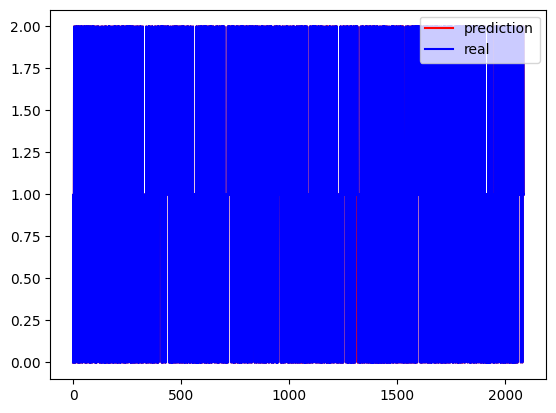

In [91]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

y_pred = model.predict(X_test)
a, b = list(), list()
for i, item in enumerate(y_pred):
    a.append(np.argmax(item))
    b.append(np.argmax(y_test[i]))

plt.plot(a, "r")
plt.plot(b, "b")
plt.legend(["prediction", "real"], loc="upper right")